In [1]:
from datasets import load_dataset
minds = load_dataset("PolyAI/minds14", name="en-AU", split="train", trust_remote_code=True)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})

In [2]:
from datasets import Audio

minds = minds.cast_column("audio", Audio(sampling_rate=16_000))

In [3]:
minds[0]

{'path': '/teamspace/studios/this_studio/.cache/huggingface/datasets/downloads/extracted/02889adf80bc6103bb58df021e360f1b594319f40059d87953dcab9c5d45c2bf/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/teamspace/studios/this_studio/.cache/huggingface/datasets/downloads/extracted/02889adf80bc6103bb58df021e360f1b594319f40059d87953dcab9c5d45c2bf/en-AU~PAY_BILL/response_4.wav',
  'array': array([2.36119668e-05, 1.92324660e-04, 2.19284790e-04, ...,
         9.40907281e-04, 1.16613181e-03, 7.20883254e-04]),
  'sampling_rate': 16000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

## Filtering

In [4]:
MAX_DURATION_IN_SECONDS = 20.0


def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS

In [5]:
import librosa
# use librosa to get example's duration from the audio file
new_column = [librosa.get_duration(path=x) for x in minds["path"]]
minds = minds.add_column("duration", new_column)

# use 🤗 Datasets' `filter` method to apply the filtering function
minds = minds.filter(is_audio_length_in_range, input_columns=["duration"])

# remove the temporary helper column
minds = minds.remove_columns(["duration"])
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 624
})

## Transformations

In [6]:
# !pip install transformers

In [7]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

In [8]:
def prepare_dataset(example):
    audio = example["audio"]
    features = feature_extractor(
        audio["array"], sampling_rate=audio["sampling_rate"], padding=True
    )
    return features

In [9]:
minds = minds.map(prepare_dataset)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id', 'input_features'],
    num_rows: 624
})

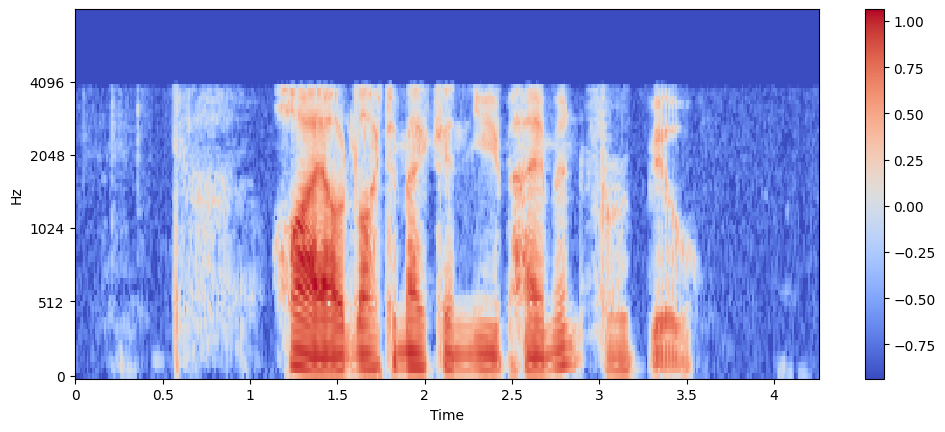

In [10]:
import numpy as np
import matplotlib.pyplot as plt

example = minds[4]
input_features = example["input_features"]

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length,
)
plt.colorbar()